## POS tagging using modified Viterbi

### Data Preparation

In [0]:
#Importing libraries
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [0]:
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [0]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [0]:
# first few tagged sentences
print(nltk_data[:20])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [0]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('``', '.'), ('The', 'DET'), ('recent', 'ADJ'), ('rally', 'NOUN'), ('in', 'ADP'), ('precious', 'ADJ'), ('metals', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('result', 'NOUN'), ('of', 'ADP'), ('uncertainty', 'NOUN'), ('and', 'CONJ'), ('volatility', 'NOUN'), ('in', 'ADP'), ('equities', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('said', 'VERB'), ('*T*-1', 'X'), ('.', '.')], [('Santa', 'NOUN'), ('Fe', 'NOUN'), ('Pacific', 'NOUN'), ('dropped', 'VERB'), ('1', 'NUM'), ('1\\/8', 'NUM'), ('to', 'PRT'), ('17', 'NUM'), ('3\\/4', 'NUM'), ('.', '.')], [('John', 'NOUN'), ('D.', 'NOUN'), ('Carney', 'NOUN'), (',', '.'), ('45', 'NUM'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('succeed', 'VERB'), ('Mr.', 'NOUN'), ('Hatch', 'NOUN'), ('as', 'ADP'), ('president', 'NOUN'), ('of', 'ADP'), ('Eastern', 'NOUN'), ('Edison', 'NOUN'), ('.', '.')], [('Sen.', 'NOUN'), ('Danforth', 'NOUN'), ('and', 'CONJ'), ('others', 'NOUN'), ('also', 'ADV'), ('want', 'VERB'), ('

In [0]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95834

In [0]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['``',
 'The',
 'recent',
 'rally',
 'in',
 'precious',
 'metals',
 'was',
 'a',
 'result']

In [0]:
# vocabulary
V = set(tokens)
print(len(V))

12099


In [0]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [0]:
print(T)

{'X', 'DET', 'NOUN', 'PRON', 'ADP', 'ADJ', 'ADV', 'VERB', 'CONJ', '.', 'NUM', 'PRT'}


POS Tagging Algorithm - HMM :

Emission Probabilities :

In [0]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [0]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

Transition Probabilities :

In [0]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [0]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [0]:
tags_matrix

array([[7.42558613e-02, 5.58898039e-02, 6.14312850e-02, 5.50981648e-02,
        1.45186827e-01, 1.72577575e-02, 2.56491452e-02, 2.04243198e-01,
        1.07663078e-02, 1.62444592e-01, 2.69157696e-03, 1.85085490e-01],
       [4.58052084e-02, 5.66538097e-03, 6.37656689e-01, 3.61620053e-03,
        9.28158127e-03, 2.05279648e-01, 1.25361616e-02, 3.96576673e-02,
        4.82160074e-04, 1.79604627e-02, 2.18177438e-02, 2.41080037e-04],
       [2.92374268e-02, 1.30550200e-02, 2.64882356e-01, 4.72744461e-03,
        1.77133709e-01, 1.22186262e-02, 1.67642459e-02, 1.46696240e-01,
        4.28742878e-02, 2.39572346e-01, 9.12760478e-03, 4.37106788e-02],
       [9.42307711e-02, 9.61538497e-03, 2.10384622e-01, 8.07692297e-03,
        2.23076921e-02, 7.42307678e-02, 3.42307687e-02, 4.82692301e-01,
        4.61538462e-03, 3.96153852e-02, 7.69230770e-03, 1.23076923e-02],
       [3.42662558e-02, 3.23720336e-01, 3.22336912e-01, 6.89581782e-02,
        1.62817929e-02, 1.06097691e-01, 1.33021176e-02, 8.51

In [0]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [0]:
tags_df

,X,DET,NOUN,PRON,ADP,ADJ,ADV,VERB,CONJ,.,NUM,PRT
X,0.074256,0.055890,0.061431,0.055098,0.145187,0.017258,0.025649,0.204243,0.010766,0.162445,0.002692,0.185085
DET,0.045805,0.005665,0.637657,0.003616,0.009282,0.205280,0.012536,0.039658,0.000482,0.017960,0.021818,0.000241
NOUN,0.029237,0.013055,0.264882,0.004727,0.177134,0.012219,0.016764,0.146696,0.042874,0.239572,0.009128,0.043711
PRON,0.094231,0.009615,0.210385,0.008077,0.022308,0.074231,0.034231,0.482692,0.004615,0.039615,0.007692,0.012308
ADP,0.034266,0.323720,0.322337,0.068958,0.016282,0.106098,0.013302,0.008513,0.000851,0.040758,0.063531,0.001383
ADJ,0.021207,0.004767,0.699984,0.000658,0.077593,0.066250,0.004932,0.012329,0.016604,0.063456,0.021042,0.011179
ADV,0.023100,0.065952,0.032139,0.015400,0.120522,0.128892,0.078674,0.347171,0.007365,0.134583,0.031804,0.014396
VERB,0.218312,0.133731,0.111094,0.035119,0.091557,0.065509,0.080704,0.168540,0.005504,0.034809,0.022715,0.032406
CONJ,0.008299,0.118027,0.348548,0.060396,0.052098,0.118027,0.053942,0.158137,0.000461,0.035500,0.041494,0.005071
.,0.026949,0.173733,0.222781,0.065397,0.090909,0.043927,0.052372,0.088843,0.058390,0.093514,0.080758,0.002336


In [0]:
tags_df.loc['.', :]

X       0.026949
DET     0.173733
NOUN    0.222781
PRON    0.065397
ADP     0.090909
ADJ     0.043927
ADV     0.052372
VERB    0.088843
CONJ    0.058390
.       0.093514
NUM     0.080758
PRT     0.002336
Name: ., dtype: float32

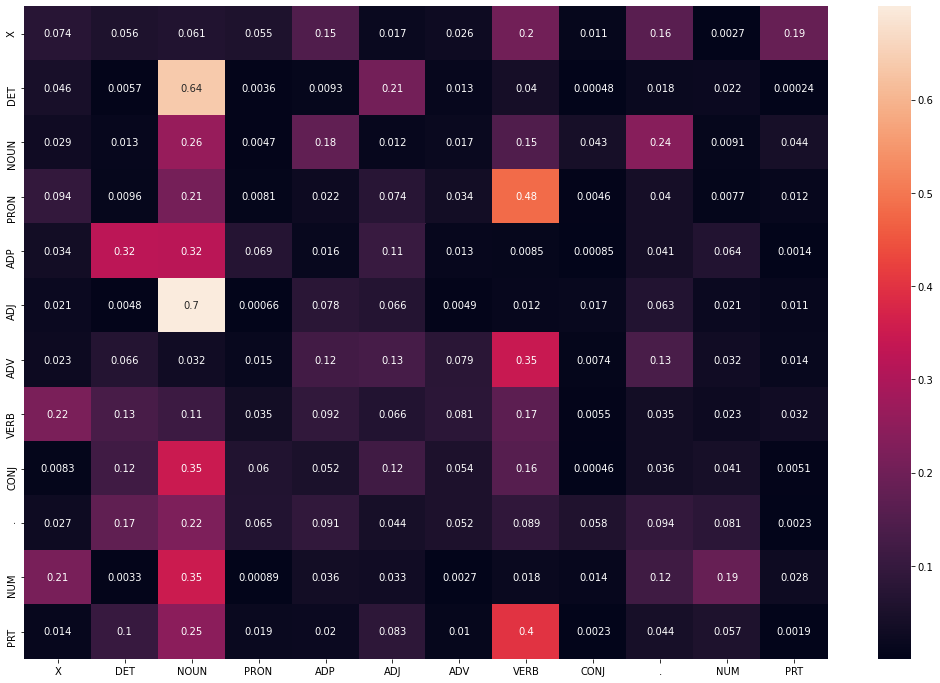

In [0]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot = True)
plt.show()

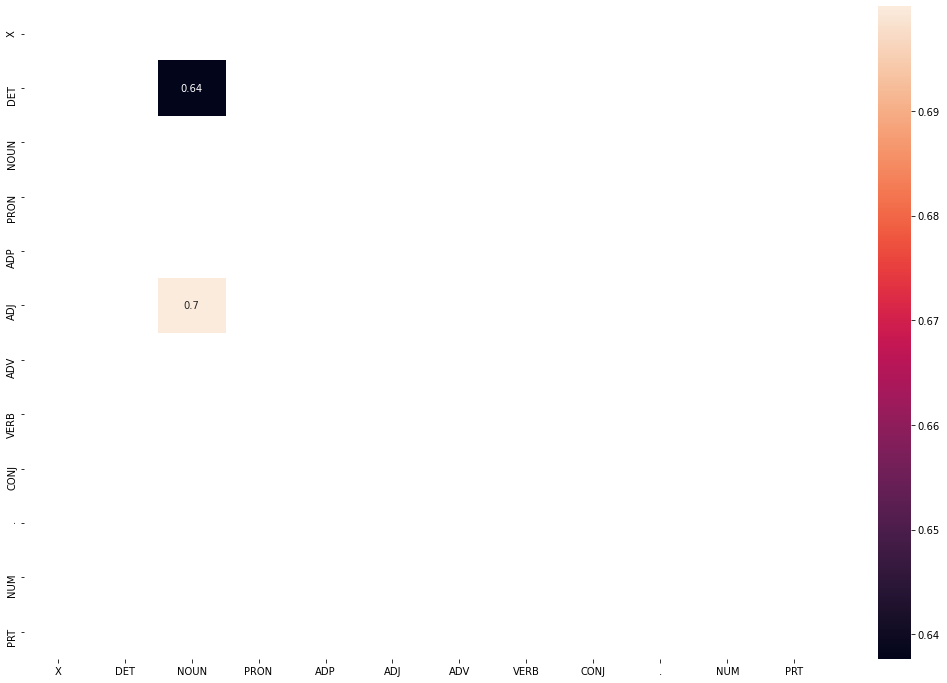

In [0]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot = True)
plt.show()


In [0]:
len(train_tagged_words)

95834

### Build the vanilla Viterbi based POS tagger

In [0]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

Evaluating on Test Set :

In [0]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('CALL', 'NOUN'),
  ('MONEY', 'NOUN'),
  (':', '.'),
  ('9', 'NUM'),
  ('3\\/4', 'NUM'),
  ('%', 'NOUN'),
  ('.', '.')],
 [('Most', 'ADV'),
  ('important', 'ADJ'),
  (',', '.'),
  ('Ms.', 'NOUN'),
  ('Ganes', 'NOUN'),
  ('noted', 'VERB'),
  ('0', 'X'),
  ('*T*-2', 'X'),
  (',', '.'),
  ('``', '.'),
  ('Brazilian', 'ADJ'),
  ('officials', 'NOUN'),
  ('said', 'VERB'),
  ('that', 'ADP'),
  ('no', 'DET'),
  ('decision', 'NOUN'),
  ('has', 'VERB'),
  ('as', 'ADV'),
  ('yet', 'ADV'),
  ('been', 'VERB'),
  ('made', 'VERB'),
  ('*-1', 'X'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('suspension', 'NOUN'),
  ('of', 'ADP'),
  ('exports', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('``', '.'),
  ('The', 'DET'),
  ('economy', 'NOUN'),
  ('is', 'VERB'),
  ('clearly', 'ADV'),
  ('slowing', 'VERB'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Robert', 'NOUN'),
  ('Black', 'NOUN'),
  (',', '.'),
  ('president', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('Richmond', 'NOUN'),
 

In [0]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [0]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  12.622704982757568
[('CALL', 'X'), ('MONEY', 'X'), (':', '.'), ('9', 'NUM'), ('3\\/4', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('Most', 'ADJ'), ('important', 'ADJ'), (',', '.'), ('Ms.', 'NOUN'), ('Ganes', 'NOUN'), ('noted', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), (',', '.'), ('``', '.'), ('Brazilian', 'ADJ'), ('officials', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), ('no', 'DET'), ('decision', 'NOUN'), ('has', 'VERB'), ('as', 'ADP'), ('yet', 'ADV'), ('been', 'VERB'), ('made', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('suspension', 'NOUN'), ('of', 'ADP'), ('exports', 'NOUN'), ('.', '.'), ("''", '.'), ('``', '.'), ('The', 'DET'), ('economy', 'NOUN'), ('is', 'VERB'), ('clearly', 'ADV'), ('slowing', 'VERB'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Robert', 'NOUN'), ('Black', 'NOUN'), (',', '.'), ('president', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Richmond', 'NOUN'), ('Federal', 'NOUN'), ('Reserve', 'NOUN'), ('Bank', 'NOUN'), ('.', '.'),

In [0]:
# Accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
accuracy_vanilla_viterbi

0.8850574712643678

In [0]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('CALL', 'X'), ('CALL', 'NOUN'))],
 [('CALL', 'NOUN'), (('MONEY', 'X'), ('MONEY', 'NOUN'))],
 [('.', '.'), (('Most', 'ADJ'), ('Most', 'ADV'))],
 [('has', 'VERB'), (('as', 'ADP'), ('as', 'ADV'))],
 [('a', 'DET'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('Jersey-based', 'X'), ('Jersey-based', 'ADJ'))],
 [('concern', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('the', 'DET'), (('Purepac', 'X'), ('Purepac', 'NOUN'))],
 [('Purepac', 'NOUN'), (('label', 'X'), ('label', 'NOUN'))],
 [('Some', 'DET'), (('long-tenured', 'X'), ('long-tenured', 'ADJ'))]]

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
## Testing
sentence_test = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [0]:
print(tagged_seq)
print(difference)

[('The', 'DET'), ('2018', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'X'), ('contested', 'X'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]
3.1471447944641113


### Solve the problem of unknown words

Method 1 :

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below -

If word in unknown then

consider only the transition_p (emission probability being 0)

else

consider both the emission and transition probability.

In [0]:
# building the train vocabulary to a set

training_vocabulary_set = set(tokens)

In [0]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [0]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm after implementing Method 1 to handle unknown words is -", optimized_viterbi_accuracy)

Accuracy of the Vanilla Viterbi Algorithm after implementing Method 1 to handle unknown words is - 0.9310344827586207


Observation 1 :

The modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) 93.1% comapred to 88.5% of the vanilla viterbi.

Method 2 :

Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [0]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [0]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [0]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("Accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

Accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9540229885057471


Observation 2 :
The modified viterbi algorithm using the method 2 performs better than the original vanilla viterbi algorithm and the method 1 modified viterbi algorithm. The modified viterbi of methdo 2 achieves an accuracy of (approx.) 95.4% comapred to 93.1% of the method 1 viterbi algorithm.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [0]:
# Lets check the tagging accuracy on the test_set data generated using the test_train_split :
acccuracy_data = [['Vanilla Viterbi', accuracy_vanilla_viterbi*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,88.505747
Optimized Vanilla Viterbi,93.103448
Viterbi + Trigram_tagger,95.402299


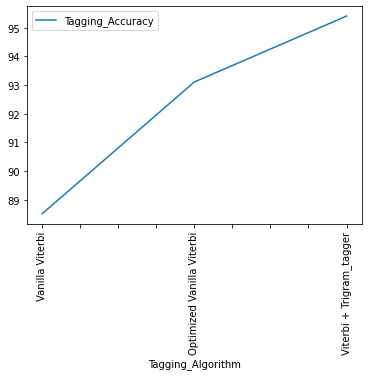

In [0]:
acccuracy_data_df.plot.line(rot = 90, legend = True)

In [0]:
#Lets check the tagging accuracies for the algorithm on the sample test sentences provided :
sample_test_sentences = ["Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'),
  ('social', 'ADJ'),
  ('networking', 'NOUN'),
  ('service', 'NOUN'),
  ('on', 'ADP'),
  ('which', 'DET'),
  ('users', 'NOUN'),
  ('post', 'NOUN'),
  ('and', 'CONJ'),
  ('interact', 'NOUN'),
  ('with',

In [0]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [0]:
#Testing the accuracy of Vanilla Viterbi on sample test data -
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

Accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7543859649122807


In [0]:
#Testing the accuracy of Vanilla Viterbi for Unknown Words (Method1) on sample test data -
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("Accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

Accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.8596491228070176


In [0]:
#Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data -
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("Accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

Accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9239766081871345


In [0]:
#Comparing the accuracies of the 3 algorithm on sample test data -
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.438596
Optimized Vanilla Viterbi,85.964912
Viterbi + Trigram_tagger,92.397661


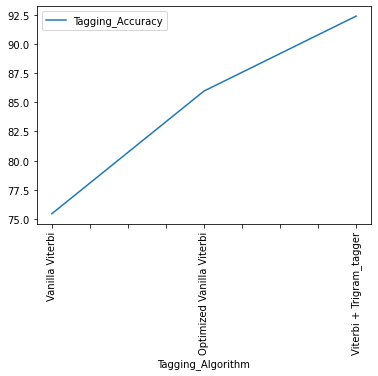

In [0]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = True)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [0]:
test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

Case 1 :

In [0]:
test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [0]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, X)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, X)","(Google, NOUN)"
9,"(., .)","(., .)"


Case - 2 :

In [0]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'X'), ('contested', 'X'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [0]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, X)","(2018, NUM)"
2,"(FIFA, X)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, X)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, X)","(21st, NUM)"
8,"(FIFA, X)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


OBSERVATIONS :

We saw that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the modified viterbi algorithms.

In this analysis we used 2 modification techniques for the original vanilla viterbi -

Method 1 -
- We used only the transition probability for unknown words.
- This method showed an increase in the accuracy (93.1%) but still had some incorrect classification.

Method 2 -
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- This gave us an accuracy of 95.4% on the test data.
- Also on testing this model on the provided sample test data, it achieved an accuracy of 92.4% and comes out to be the winner.